In [1]:

!pip install --upgrade pip #restart
!pip install --upgrade qiskit
!pip install --upgrade qiskit-machine-learning
!pip install 'qiskit-machine-learning[sparse]'
!pip install tensorflow
#restart kernel

  Using cached pip-23.3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.1.1
    Uninstalling pip-23.1.1:
      Successfully uninstalled pip-23.1.1
  Using cached qiskit-0.45.1-py3-none-any.whl.metadata (12 kB)
  Using cached qiskit_terra-0.45.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached qiskit-0.45.1-py3-none-any.whl (9.6 kB)
Using cached qiskit_terra-0.45.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.3 MB)
  Attempting uninstall: qiskit-terra
    Found existing installation: qiskit-terra 0.25.3
    Uninstalling qiskit-terra-0.25.3:
      Successfully uninstalled qiskit-terra-0.25.3
  Attempting uninstall: qiskit
    Found existing installation: qiskit 0.44.3
    Uninstalling qiskit-0.44.3:
      Successfully uninstalled qiskit-0.44.3

[notice] A new release of pip is available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached qiskit_machine_lear

In [2]:
# Importing standard Qiskit libraries
import qiskit
from qiskit import QuantumCircuit, transpile, Aer
from qiskit import BasicAer, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *


#from qiskit.visualization import plot_histogram

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()


import numpy as np
from PIL import Image 
import pickle # to serialize and deserialize variables
import matplotlib.pyplot as plt
import tensorflow as tf

from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import ZZFeatureMap, TwoLocal, RealAmplitudes
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler




algorithm_globals.random_seed = 3142
np.random.seed(algorithm_globals.random_seed)

2023-12-09 22:13:23.477951: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-09 22:13:23.640172: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 22:13:23.640948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 22:13:23.643211: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 22:13:23.659358: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-09 22:13:23.673802: I tensorflow/core/platform/cpu_feature_guard.cc:1

Variational algorithms | variational quantum classifier
- | -
![title](https://learn.qiskit.org/content/v2/quantum-machine-learning/images/vqc/va.svg) | ![title](https://learn.qiskit.org/content/v2/quantum-machine-learning/images/vqc/vqc.svg)   

In [3]:

TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)

/opt/conda/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


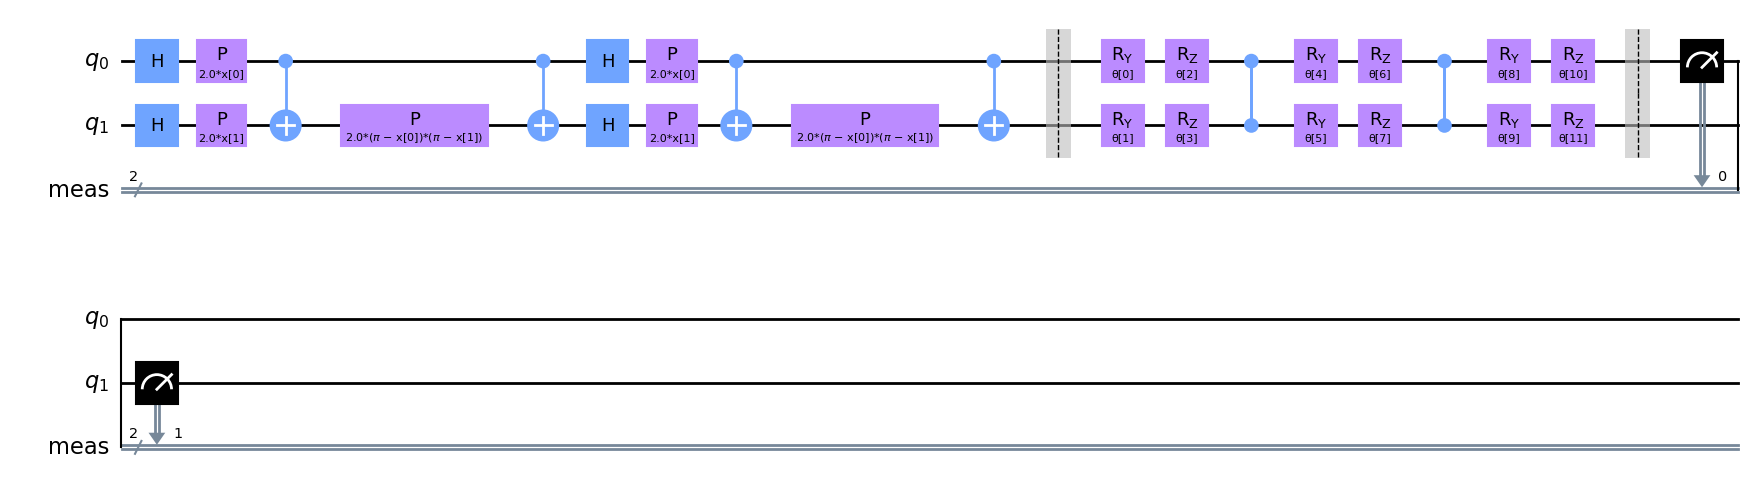

In [4]:
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

# generator = TwoLocal(REAL_DIST_NQUBITS,
#                      # Parameterized single qubit rotations
#                      ['ry', 'rz'],
#                      'cz',  # Entangling gate
#                      'full', # Entanglement structure: all to all
#                      reps=2, # Number of layers
#                      parameter_prefix='θ_g',
#                      name='Generator')

FEATURE_MAP.barrier()
AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

In [5]:
def circuit_instance(data, variational): # to split in two data encoding  + parameter assignement ==> circuit instance
    """Assigns parameter values to `VARATIONAL_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `VARATIONAL_CIRCUIT` with parameters assigned
    """
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)





def parity(bitstring): #---------to change to base 2 class index
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2




def label_probability(results): # to change to prob index occurence : eg result = { 0001, }
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

In [6]:


def classification_probability(data, variational): #batch execution
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()
    classification = [
        label_probability(results.get_counts(c)) for c in circuits]
    return classification



def cross_entropy_loss(classification, expected): #check wih tf loss
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)


def cost_function(data, labels, variational): # batch loss reduction
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost


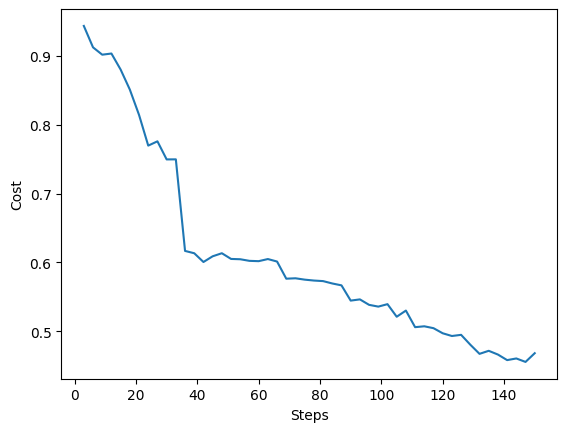

In [7]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

# Set up the optimization
log = OptimizerLog()
optimizer = SPSA(maxiter=50, callback=log.update)

#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun


fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [3]:
NBR_QBIT = 7

IMG_HEIGHT = NBR_QBIT
IMG_WIDTH  = 7
IMG_NUM_CHANNEL = 1

DATA_ENCODING_DEPTH = IMG_WIDTH
CIRQ_HEIGHT = NBR_QBIT

NBR_CLASS = 10


print("IMG_HEIGHT: {}; IMG_WIDTH: {}".format(IMG_HEIGHT, IMG_WIDTH),  "---->",   "NBR_QBIT: {}; DATA_ENCODING_DEPTH: {}".format(NBR_QBIT, DATA_ENCODING_DEPTH),  "NBR_CLASS : {}".format(NBR_CLASS) )



assert 2**NBR_QBIT - 1 >= NBR_CLASS #because in the interpreter we will use int(measurement)%NBR_LABEL = predicted class

IMG_HEIGHT: 7; IMG_WIDTH: 7 ----> NBR_QBIT: 7; DATA_ENCODING_DEPTH: 7 NBR_CLASS : 10


In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
def encode_matrix(inp_mat):
    output_img = np.zeros_like(inp_mat, float);
    r, c = inp_mat.shape[:2]

    def kernel(i, j): #use some classical kernel so theta(i,j) = f( (i, j), neighborhood(i, j)); eg. conv 2D

        return inp_mat[i][j]

    
    for i in range(r):
        for j in range(c):
            output_img[i][j] = kernel(i, j)

    #Column wise data encoding to match Data Encoder <ordered_parameters>
    return np.concatenate( tuple( output_img[:, i] for i in range(c) ), axis = 0)


def preprocess_inp(inp_img):
    inp_img = Image.fromarray(inp_img);
    inp_img = inp_img.resize(size = ( IMG_WIDTH, IMG_HEIGHT),  resample = Image.BICUBIC );
    inp_img = np.asarray( inp_img );
    
    return encode_matrix(inp_img)
    



In [6]:
#preprocess input data
x_train = [ preprocess_inp(elt) for elt in x_train ]
x_test  = [ preprocess_inp(elt) for elt in x_test  ]


/tmp/ipykernel_60/291718804.py:20: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  inp_img = inp_img.resize(size = ( IMG_WIDTH, IMG_HEIGHT),  resample = Image.BICUBIC );


/tmp/ipykernel_60/254684816.py:21: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  inp_img = inp_img.resize(size = ( IMG_WIDTH, IMG_HEIGHT),  resample = Image.BICUBIC );


/opt/conda/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


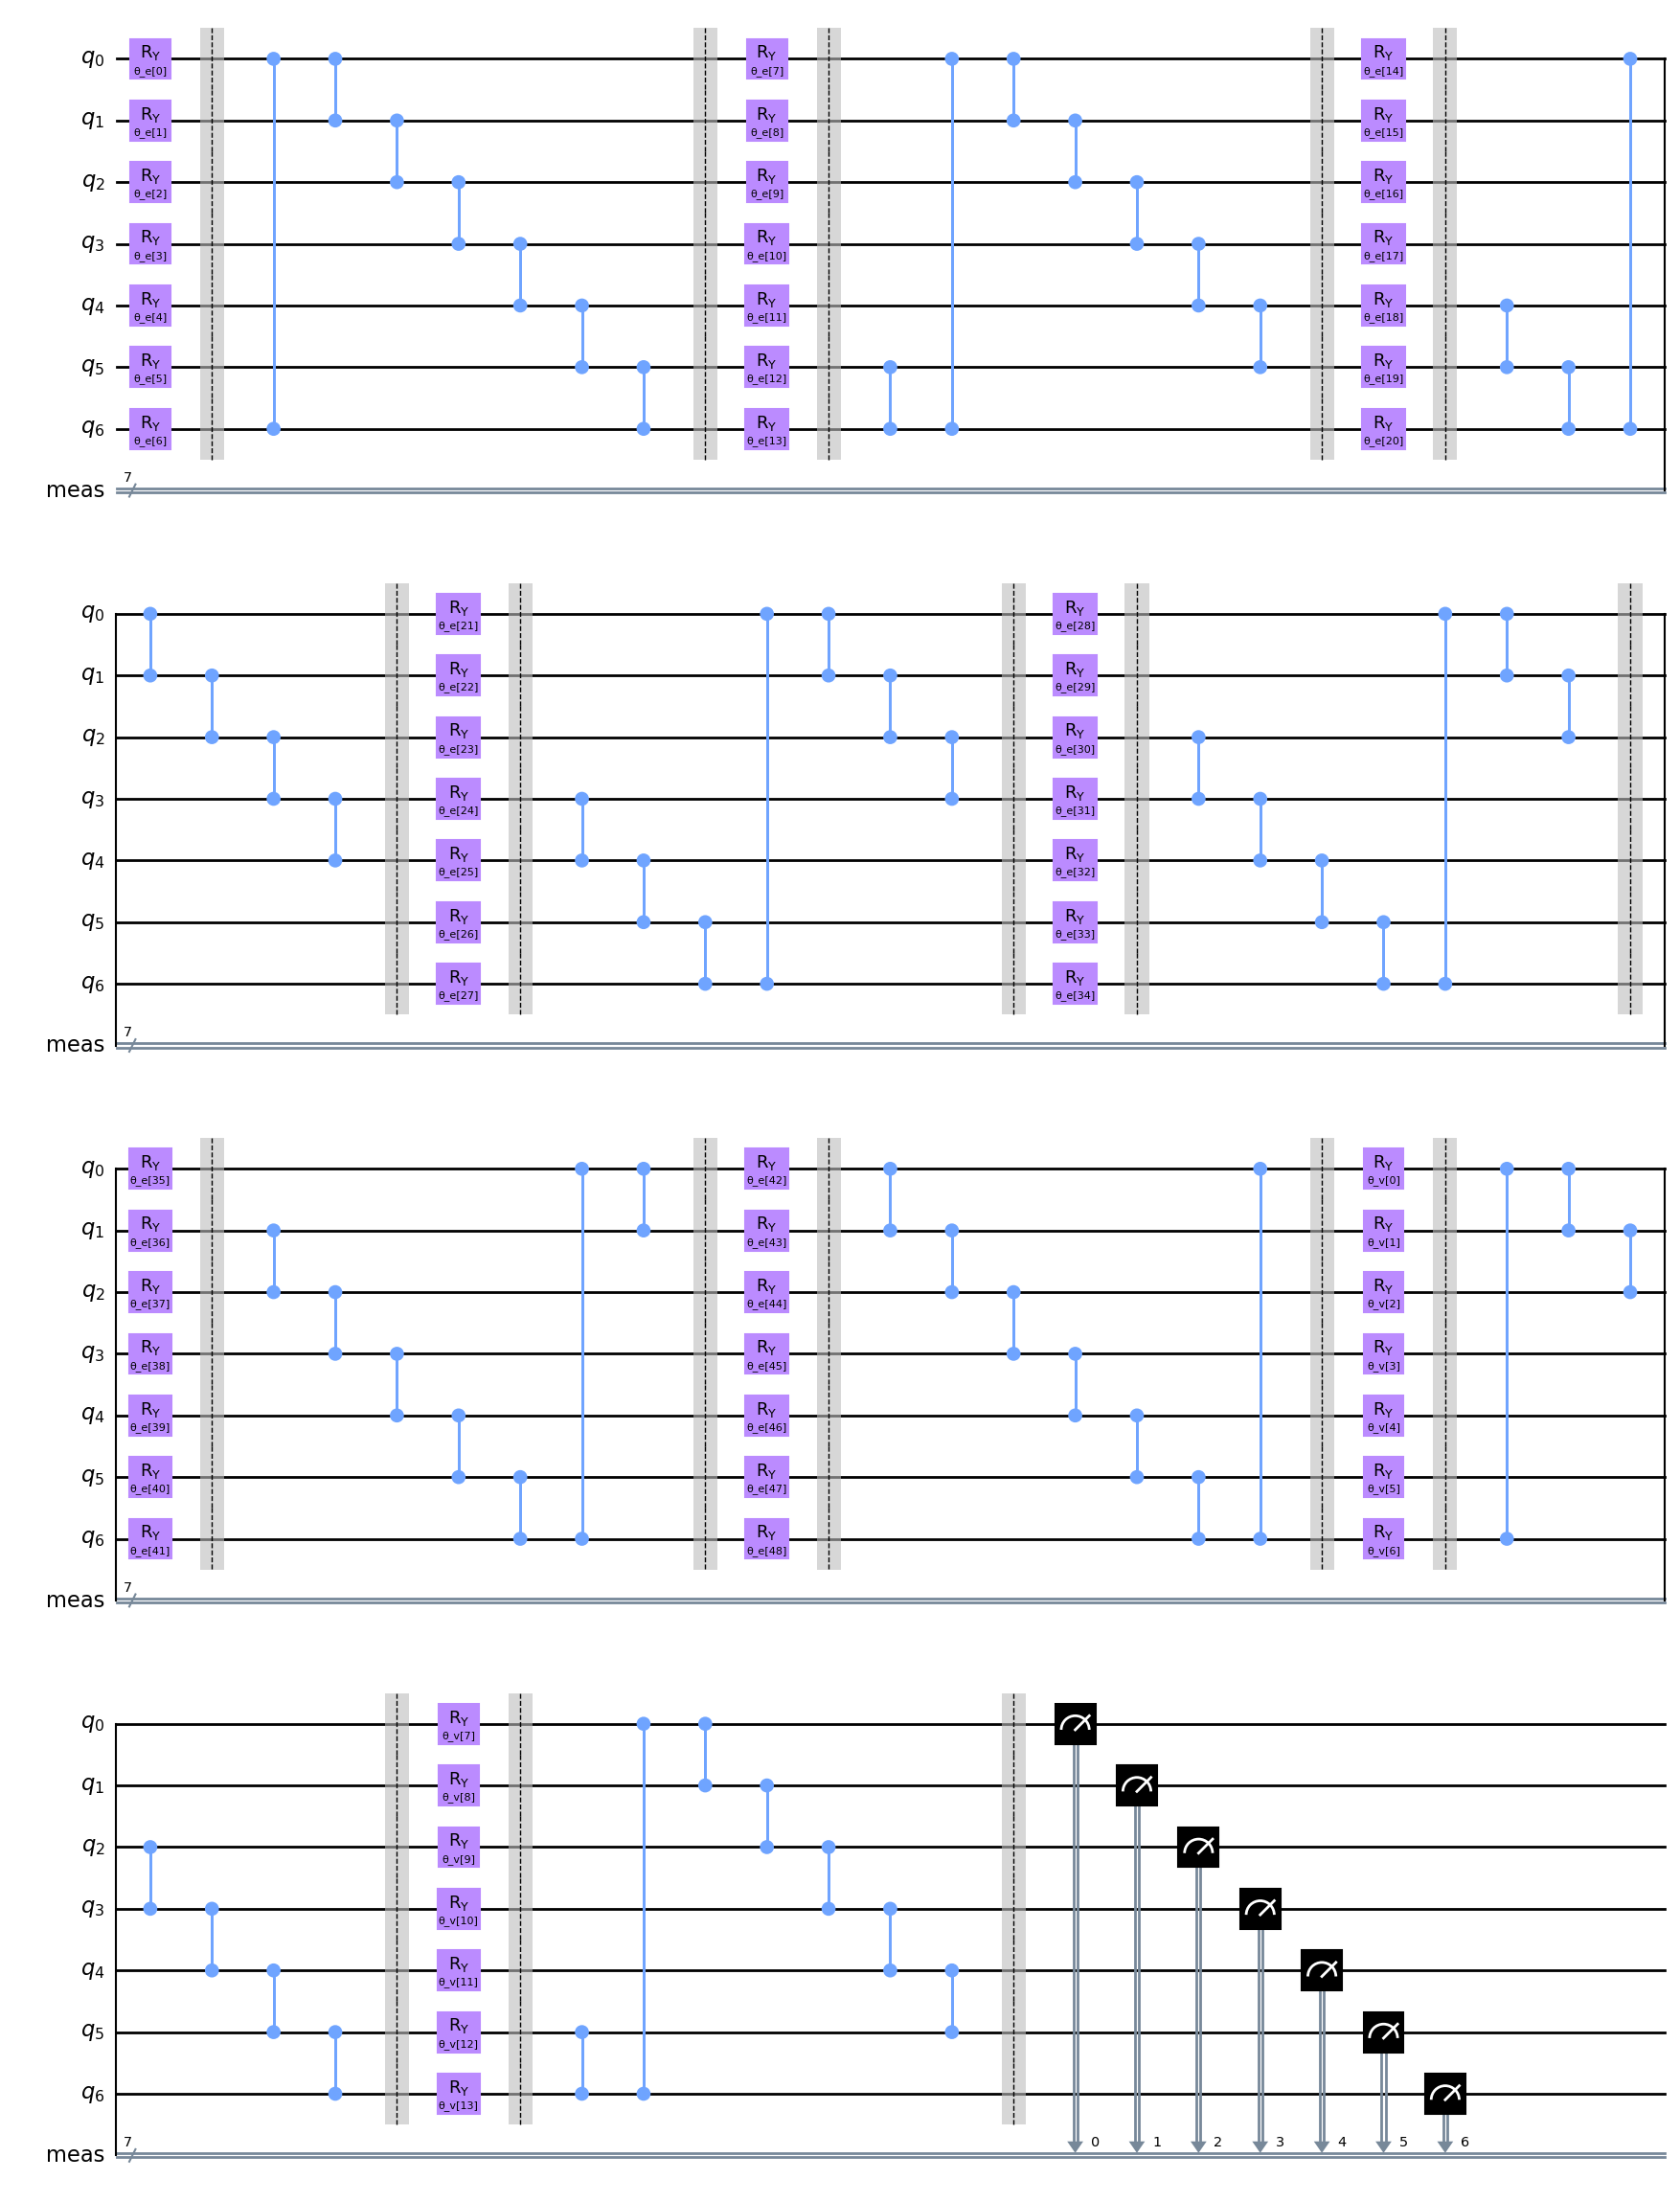

In [7]:




def data_encoder(reps = DATA_ENCODING_DEPTH, display_qc=False):
    #return ZZFeatureMap(feature_dimension=NBR_QBIT, reps=reps)
    rotation_blocks = ['ry','rz', 'rx']
    entanglement_blocks = ['cz', ]# 'crz' ]
    entanglement = [ 'sca',  'full',   ][:1]
    
    qc_twolocal = TwoLocal(num_qubits=NBR_QBIT, reps=reps, rotation_blocks=rotation_blocks[:IMG_NUM_CHANNEL],
                            entanglement_blocks=entanglement_blocks, entanglement=entanglement, 
                           skip_final_rotation_layer=True, insert_barriers=True, name='Data_Encoder', parameter_prefix='θ_e',
                )

    if display_qc : qc_twolocal.decompose().draw()
    return qc_twolocal
    

    

def varational_qc(reps = 2, display_qc=False):
    rotation_blocks = ['ry','rz', 'rx']
    entanglement_blocks = ['cz', ]# 'crz' ]
    entanglement = [ 'sca',  'full',   ][:1]
    
    qc_twolocal = TwoLocal(num_qubits=NBR_QBIT, reps=reps, rotation_blocks=rotation_blocks[:IMG_NUM_CHANNEL],
                            entanglement_blocks=entanglement_blocks, entanglement=entanglement, 
                           skip_final_rotation_layer=True, insert_barriers=True, name='VAR_FORM', parameter_prefix='θ_v',
                )

    if display_qc : qc_twolocal.decompose().draw()
    
    
    return qc_twolocal
    



def build_complet_cirq( mesure=False, display_qc = False):
    
    qcirq = QuantumCircuit(NBR_QBIT)
    qcirq.compose(FEATURE_MAP, inplace=True)
    qcirq.barrier()
    qcirq.compose(VAR_FORM, inplace=True)
    if mesure : qcirq.measure_all()
    if display_qc: display(qcirq.decompose().draw())
    return qcirq
    

    
    
    
    
def circuit_instance(inp_data, weight_params): # to split in two data encoding  + parameter assignement ==> circuit instance
    """Assigns parameter values to `VARATIONAL_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `VARATIONAL_CIRCUIT` with parameters assigned
    """
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = inp_data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = weight_params[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)


FEATURE_MAP = data_encoder();
VAR_FORM = varational_qc();
AD_HOC_CIRCUIT = build_complet_cirq(mesure=True, display_qc=True)

In [8]:



def measurementInterpreter(x): #convert autput to label index, taking account 
    #print(x)
    #ans = f"{bin(x)}".count("1") % 2 #parity
    ans = int(x, 2)%NBR_CLASS
    return ans
    


def softmax(x): #Numerically Stable softmax
    x = np.array(x)
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(y)
    return f_x

    
def label_probability(results): # to change to prob index occurence : eg result = { 0001, }
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values()) #sum of nbr count
    #probabilities = {i : 0 for i in range(NBR_CLASS)}
    probabilities = [0] * NBR_CLASS 
    for bitstring, counts in results.items():
        label = measurementInterpreter(bitstring)
        probabilities[label] += counts / shots
    
    return softmax( probabilities )

    

    
def classification_probability(data, variational): #batch execution
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()
    classification = [
        label_probability(results.get_counts(c)) for c in circuits]
    return classification



def cross_entropy_loss(classification, expected): #check wih tf loss
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)



def sparse_categorical_crossentropy( y_pred,  y_true):# reduce Mean Over Batch
    # convert true labels to one-hot encoding
    y_true_onehot = np.zeros_like(y_pred)
    y_true_onehot[np.arange(len(y_true)), y_true] = 1

    # calculate loss
    y_pred = [_yy + 1e-10 for _yy in y_pred]
    loss = -np.mean(np.sum(y_true_onehot * np.log(y_pred), axis=-1))

    return loss



def eval_circuit_instance( data, labels, variational ) :
    classifications = classification_probability(data, variational)
    loss = sparse_categorical_crossentropy( classifications,  labels)
    return classifications, loss



def cost_function(data, labels, variational): # batch loss reduction
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    _, cost = eval_circuit_instance( data, labels, variational )
    return cost

    
    

    
    
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

        

class Training:
    def __init__(self, x_train, y_train,  x_test, y_test, batch_size = 100):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        
        self.train_len = len( y_train )
        self.test_len  = len( y_test )
        
        self.batch_size = batch_size
        self.train_idx  = 0;
        self.test_idx   = 0;
        
        
    def next_train(self,):
        if( self.train_idx * self.batch_size > self.train_len  ):
            self.train_idx = 0;
        start = self.train_idx * self.batch_size
        end   = start + self.batch_size
        self.train_idx += 1
        return self.x_train[ start : end ], self.y_train[ start : end ]
    

    def next_test(self,):
        if( self.test_idx * self.batch_size > self.test_len  ):
            self.test_idx = 0;
        start = self.test_idx * self.batch_size
        end   = start + self.batch_size
        self.test_idx += 1
        return self.x_test[ start : end ], self.y_test[ start : end ]
        

    def objective_function(self, variational):
        """Cost function of circuit parameters on training data.
        The optimizer will attempt to minimize this."""
        
        TRAIN_DATA,  TRAIN_LABELS   = self.next_train()

        return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)


    def evaluate_model(self, params, ):
        TEST_DATA, TEST_LABELS   = self.next_test()
        
        eval_classification, eval_lost = eval_circuit_instance( TEST_DATA, TEST_LABELS, params )
        y_pred   = [ np.argmax(a_prob , )  for a_prob in eval_classification]
        y_pred   = [ a == b for a, b in zip(TEST_LABELS,  y_pred) ]   
        eval_acc = sum(y_pred)/len(y_pred)

        print("evaluation res: acc: {};  loss: {} ".format(eval_acc,  eval_lost) )

        return { "eval_acc" : eval_acc,  "eval_lost"  :  eval_lost} 
    
    
    


In [ ]:

def train_model(batch_size = 10, maxiter=100):
    
    eval_step = 3;
    nbr_epoch  = 10
    
    training = Training(x_train = x_train, y_train = y_train,  x_test = x_test, y_test=y_test, batch_size = batch_size)
    
    # Set up the optimization
    log = OptimizerLog()
    optimizer = SPSA(maxiter=maxiter, callback=log.update)
    
    initial_point = np.random.random(VAR_FORM.num_parameters)
    
    all_result = []
    
    for i in range(nbr_epoch):
        
        # Run the optimization
        result = optimizer.minimize(objective_function, initial_point)
        opt_var = result.x
        opt_value = result.fun
        
        initial_point = opt_var
        
        eval_res = None
        if (i + 1) % eval_step == 0  : eval_res = evaluate_model(params = opt_var)
        
        all_result.append(  {"train": result, "eval" : eval_res} )


        fig = plt.figure()
        plt.plot(log.evaluations, log.costs)
        plt.xlabel('Steps')
        plt.ylabel('Cost')
        plt.show()

        if eval_res == None : print( "epoch {}, ----eval".format(i) ,   eval_res)
        
        
        
train_model(batch_size = 10, maxiter=100)


In [9]:
#https://docs.quantum.ibm.com/api/qiskit/qiskit.algorithms.optimizers.SPSA#set_options


In [ ]:
initial_point = np.random.random(VAR_FORM.num_parameters)
#objective_function(initial_point)

# Set up the optimization
log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)



# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun


fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

eval_res = evaluate_model(params = opt_var)

In [ ]:
#2.2975

2.3043086374117228

In [129]:
# sampler = Sampler()
# qnn = SamplerQNN(
#     circuit=AD_HOC_CIRCUIT,
#     input_params=FEATURE_MAP.parameters,
#     weight_params=VAR_FORM.parameters,
#     #interpret=resInterpreter,
#     #output_shape=2,
#     sampler=sampler,
#     #sparse=True, # get sparse probability vector
# )





# len(FEATURE_MAP.parameters)

# inp_data = [0, 0]
# inp_weights  = [1, 2, 3, 4, 9, 0, 7, 8]
# qnn.forward(input_data=inp_data, weights= inp_weights)

array([[0.18680798, 0.18217199, 0.10730674, 0.52371329]])

[[[ 5.26966678e-02 -1.13977787e-01 -6.94383074e-02 -5.55111512e-17
   -7.51127303e-02 -1.08121209e-01  0.00000000e+00 -5.55111512e-17]
  [-5.26966678e-02 -1.72306199e-01  6.94383074e-02  0.00000000e+00
    7.51127303e-02  2.13266074e-02 -4.16333634e-17  0.00000000e+00]
  [ 1.42820824e-01 -5.15108981e-02 -8.48461179e-02  5.55111512e-17
    1.17525436e-01  1.08121209e-01  5.55111512e-17  0.00000000e+00]
  [-1.42820824e-01  3.37794884e-01  8.48461179e-02  1.11022302e-16
   -1.17525436e-01 -2.13266074e-02  0.00000000e+00  0.00000000e+00]]]


array([], shape=(0, 8), dtype=float64)

[[ 5.26966678e-02 -1.13977787e-01 -6.94383074e-02 -5.55111512e-17
  -7.51127303e-02 -1.08121209e-01  0.00000000e+00 -5.55111512e-17]
 [-5.26966678e-02 -1.72306199e-01  6.94383074e-02  0.00000000e+00
   7.51127303e-02  2.13266074e-02 -4.16333634e-17  0.00000000e+00]
 [ 1.42820824e-01 -5.15108981e-02 -8.48461179e-02  5.55111512e-17
   1.17525436e-01  1.08121209e-01  5.55111512e-17  0.00000000e+00]
 [-1.42820824e-01  3.37794884e-01  8.48461179e-02  1.11022302e-16
  -1.17525436e-01 -2.13266074e-02  0.00000000e+00  0.00000000e+00]]


(None,
 array([[[-0.31448323, -0.14709734, -0.18040398, -0.11327493,
           0.35538559,  0.13216635, -0.18040398,  0.14796371],
         [ 0.31448323,  0.14709734,  0.18040398,  0.11327493,
          -0.35538559, -0.13216635,  0.18040398, -0.14796371]]]))

array([[0.80223142, 0.19776858]])

In [116]:

# Initialize Adam optimizer from Keras
classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)



In [117]:
#display( qc_test.decompose().draw() )


In [32]:


num_qubits = 2



array([[0.66519637, 0.33480363]])